In [284]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [285]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from pulp import *
import numpy as np
from math import sqrt

In [286]:
costs1 = [[1, sqrt(2), 2], [sqrt(2), 1, sqrt(5)]]
m_start1 = [3, 1]
m_arrival1 = [1, 1, 2]

def optimal_solve(costs, m_start, m_arrival):
  # Initialise les variables du problème
  problem = LpProblem("Optimal_transport", LpMinimize)
  paths = [(i, j) for i in range(len(m_start)) for j in range(len(m_arrival))]
  path_variables = LpVariable.dicts("Path", (range(len(m_start)), range(len(m_arrival))),
                                lowBound=0, cat='Continuous')

  # Définit la fonction objective
  problem += lpSum([path_variables[i][j] * costs[i][j] for (i, j) in paths])

  # Pose les contraintes
  for i in range(len(m_start)):
      problem += lpSum([path_variables[i][j] for j in range(len(m_arrival))]) == m_start[i]
  #print(problem)
  for j in range(len(m_arrival)):
      problem += lpSum([path_variables[i][j] for i in range(len(m_start))]) == m_arrival[j]

  problem.solve()

  result = {}
  for v in problem.variables():
      route = v.name.split("_")[1:]
      i, j = int(route[0]), int(route[1])
      result[i, j] = v.varValue

  optimal_plane = np.zeros((len(m_start), len(m_arrival)))
  for i, j in result.keys():
    optimal_plane[i,j] = result[i, j]

  #print(f"Plan de transport optimal :\n{optimal_plane}")  
  #print(problem.objective)
  #print(f"Coût minimal: {value(problem.objective)}")
  return optimal_plane

optimal_solve(costs1, m_start1, m_arrival1)

array([[1., 0., 2.],
       [0., 1., 0.]])

In [287]:
costs2 = [[1, 1, 2, 1], [1, 1, 1, 2]]
m_start2 = [2, 2]
m_arrival2 = [1, 1, 1 , 1]
optimal_solve(costs2, m_start2, m_arrival2)

array([[1., 0., 0., 1.],
       [0., 1., 1., 0.]])

In [288]:
def valid_path(optimal_plane):
  list_indices_non_zero = np.argwhere(optimal_plane > 0).tolist()
  return list_indices_non_zero

In [289]:
def color_norm(color):
  return int(255-color*255)
print(color_norm(0.5))

127


In [290]:
def transport(list_indices_non_zero, start_indices, end_indices, optimal_plane, t_frac):

  image = 255 * np.ones((160,160), np.uint8)

  for coordinates in list_indices_non_zero:

    row_idx = coordinates[0]
    col_idx = coordinates[1]
    image[int(t_frac * start_indices[row_idx][0] + (1 - t_frac) * end_indices[col_idx][0])][int(t_frac * start_indices[row_idx][1] + (1 - t_frac) * end_indices[col_idx][1])] = color_norm(optimal_plane[row_idx][col_idx])

  return image

In [291]:
def rectangle(image, corner_coordinates, height, width, color):
  """
    Create a black rectangle for image
  """

  res_image = image.copy()

  x_start = corner_coordinates[0]
  y_start = corner_coordinates[1]

  for i in range(x_start, x_start+height):
      for j in range(y_start, y_start+width):
          res_image[i][j] = color_norm(color)

  return res_image

In [292]:
def get_indices_of_zeros(image):
  res = np.argwhere(image != 255).tolist()
  return res

In [293]:
def get_cost_matrix(start_indices, end_indices):

  res = np.zeros((len(start_indices), len(end_indices)))

  for row_idx in range(len(start_indices)):
      for col_idx in range(len(end_indices)):

          res[row_idx, col_idx] = math.dist(start_indices[row_idx], end_indices[col_idx])

  return res

## Test

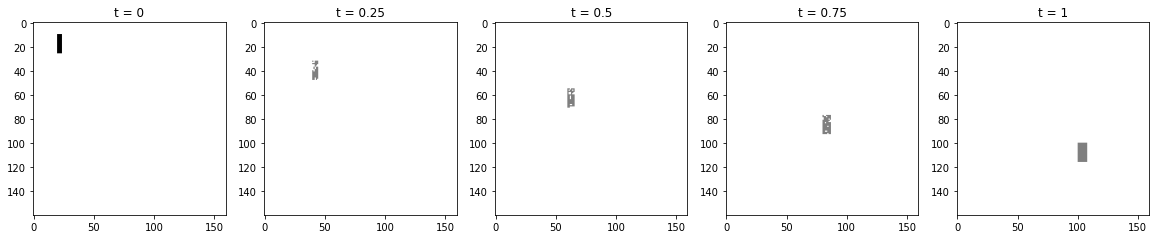

In [294]:
# Generate white backend
im1 = 255 * np.ones((160,160), dtype=np.uint8)
im2 = 255 * np.ones((160,160), dtype=np.uint8)

start_images = rectangle(im1, (10,20), 16, 4, 1)
end_images   = rectangle(im2, (100, 100), 16, 8, 0.5)

# Create figure
fig, ax = plt.subplots(1,5, figsize=(20, 20))
ax[0].imshow(start_images, cmap="gray", vmin=0, vmax=255)
ax[0].set_title("t = 0")

# Get start and end indices (indices of the rectangles)
start_indices = get_indices_of_zeros(start_image)
end_indices   = get_indices_of_zeros(end_image)

# Compute cost matrix
cost_matrix = get_cost_matrix(start_indices, end_indices)

# Solve the problem 
mass_start = [1 for i in range(len(start_indices))]
mass_end   = [0.5 for i in range(len(end_indices))]

optimal_plane = optimal_solve(cost_matrix, mass_start, mass_end)

# Compute the valid path
list_indices_non_zero = valid_path(optimal_plane)

list_t_frac = np.linspace(1/4, 3/4, 3)

i = 1

for t_frac in list_t_frac[::-1]:

  #print(list_indices_non_zero
  current_image = transport(list_indices_non_zero, start_indices, end_indices, optimal_plane, t_frac)

  ax[i].imshow(current_image, cmap="gray", vmin=0, vmax=255)
  ax[i].set_title(f"t = {1 - t_frac}")
  i += 1

ax[i].imshow(end_images, cmap="gray", vmin=0, vmax=255)
ax[i].set_title("t = 1")
plt.show()

